<a href="https://colab.research.google.com/github/sanjeevrs2000/CS6910-Assignment-2/blob/main/Assignment_2A_guided_backprop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install wandb

In [ ]:
import numpy as np
import pandas as pd
import os
import keras
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras import layers,models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from wandb.keras import WandbCallback
import matplotlib.pyplot as plt
import cv2
#import wandb
import matplotlib.image as mpimg

In [ ]:
%%capture
!curl -SL https://storage.googleapis.com/wandb_datasets/nature_12K.zip > nature_12K.zip
!unzip nature_12K.zip

train_dir='inaturalist_12K/train/'
test_dir='inaturalist_12K/val/'
categories=['Amphibia','Animalia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia']

In [ ]:
model=models.Sequential()

img_height,img_width=300,300
model.add(Conv2D(16, (3, 3),input_shape=(img_height,img_width,3),activation='relu',name='conv1'))    
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(32, (3, 3),activation='relu',name='conv2'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3),activation='relu',name='conv3'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3),activation='relu',name='conv4'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3),activation='relu',name='conv5'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(256,activation='relu')) #change dense layer size
model.add(BatchNormalization())
model.add(Dropout(0.3))


model.add(Dense(10,activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 298, 298, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 298, 298, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2 (Conv2D)               (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0

In [ ]:
img_height=300
img_width=300

augment= ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1.0 / 255,
    validation_split=0.1
)

datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.1
)

train_set = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    color_mode='rgb',
    class_mode='sparse',
    shuffle=True,
    subset='training',
    seed=123,
)

val_set = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    color_mode='rgb',
    class_mode='sparse',
    shuffle=True,
    subset='validation',
    seed=123,
)


Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=[tf.keras.losses.SparseCategoricalCrossentropy()],
    metrics=['accuracy'],
)


early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4,restore_best_weights=True)


model.fit(train_set,epochs=10,validation_data=val_set,callbacks=[early_stop])

Epoch 1/10
282/282 [==============================] - 173s 505ms/step - loss: 2.5601 - accuracy: 0.1918 - val_loss: 2.6200 - val_accuracy: 0.1622
Epoch 2/10
282/282 [==============================] - 140s 498ms/step - loss: 2.1936 - accuracy: 0.2559 - val_loss: 2.1826 - val_accuracy: 0.2513
Epoch 3/10
282/282 [==============================] - 139s 494ms/step - loss: 1.9921 - accuracy: 0.3091 - val_loss: 2.1010 - val_accuracy: 0.2873
Epoch 4/10
282/282 [==============================] - 139s 494ms/step - loss: 1.9029 - accuracy: 0.3404 - val_loss: 2.1199 - val_accuracy: 0.2903
Epoch 5/10
282/282 [==============================] - 140s 497ms/step - loss: 1.8164 - accuracy: 0.3673 - val_loss: 2.0106 - val_accuracy: 0.3123
Epoch 6/10
282/282 [==============================] - 139s 493ms/step - loss: 1.6938 - accuracy: 0.4071 - val_loss: 2.1992 - val_accuracy: 0.2793
Epoch 7/10
282/282 [==============================] - 141s 499ms/step - loss: 1.5945 - accuracy: 0.4420 - val_loss: 2.1794 -

In [ ]:
LAYER_NAME = 'conv5'

@tf.custom_gradient
def guidedRelu(x):
  def grad(dy):
    return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
  return tf.nn.relu(x), grad



def GBP(model, layer=LAYER_NAME, N_neu=10, cat = 0,fil = 2):
  gb_model = tf.keras.models.Model(
    inputs = [model.inputs],    
    outputs = [model.get_layer(LAYER_NAME).output])
  layer_dict = [layer for layer in gb_model.layers[1:] if hasattr(layer,'activation')]

  for layer in layer_dict:
    if layer.activation == tf.keras.activations.relu:
      layer.activation = guidedRelu
  category = categories[cat]
  dir=os.path.join(train_dir,category)
  fig = plt.figure(figsize=(30,20))
  for img in os.listdir(dir):
    rows = 2
    columns=5
    img_path=(os.path.join(dir,img))
    imgs=cv2.imread(img_path)
    imgs=mpimg.imread(img_path)
    new_img=cv2.resize(imgs,(300,300))
    x = np.expand_dims(new_img, axis=0)
    i=0
    j = 1
    while j <= N_neu:
      with tf.GradientTape() as tape:
        inputs = tf.cast(x, tf.float32)
        tape.watch(inputs)
        outputs = gb_model(inputs)[0]
        
      
        
        if outputs[i,i,fil] != 0:
          out = outputs[i,i,fil]
          grads = tape.gradient(out,inputs)[0]
          guided_back_prop =grads
          gb_viz = np.dstack((
                      guided_back_prop[:, :, 0],
                      guided_back_prop[:, :, 1],
                      guided_back_prop[:, :, 2],
                  ))       
          gb_viz -= np.min(gb_viz)
          gb_viz /= gb_viz.max()
          fig.add_subplot(rows,columns,j)
          plt.imshow(gb_viz)
          plt.title(category)
          j+=1
          i+=1
        else:
          i+=1  
    break

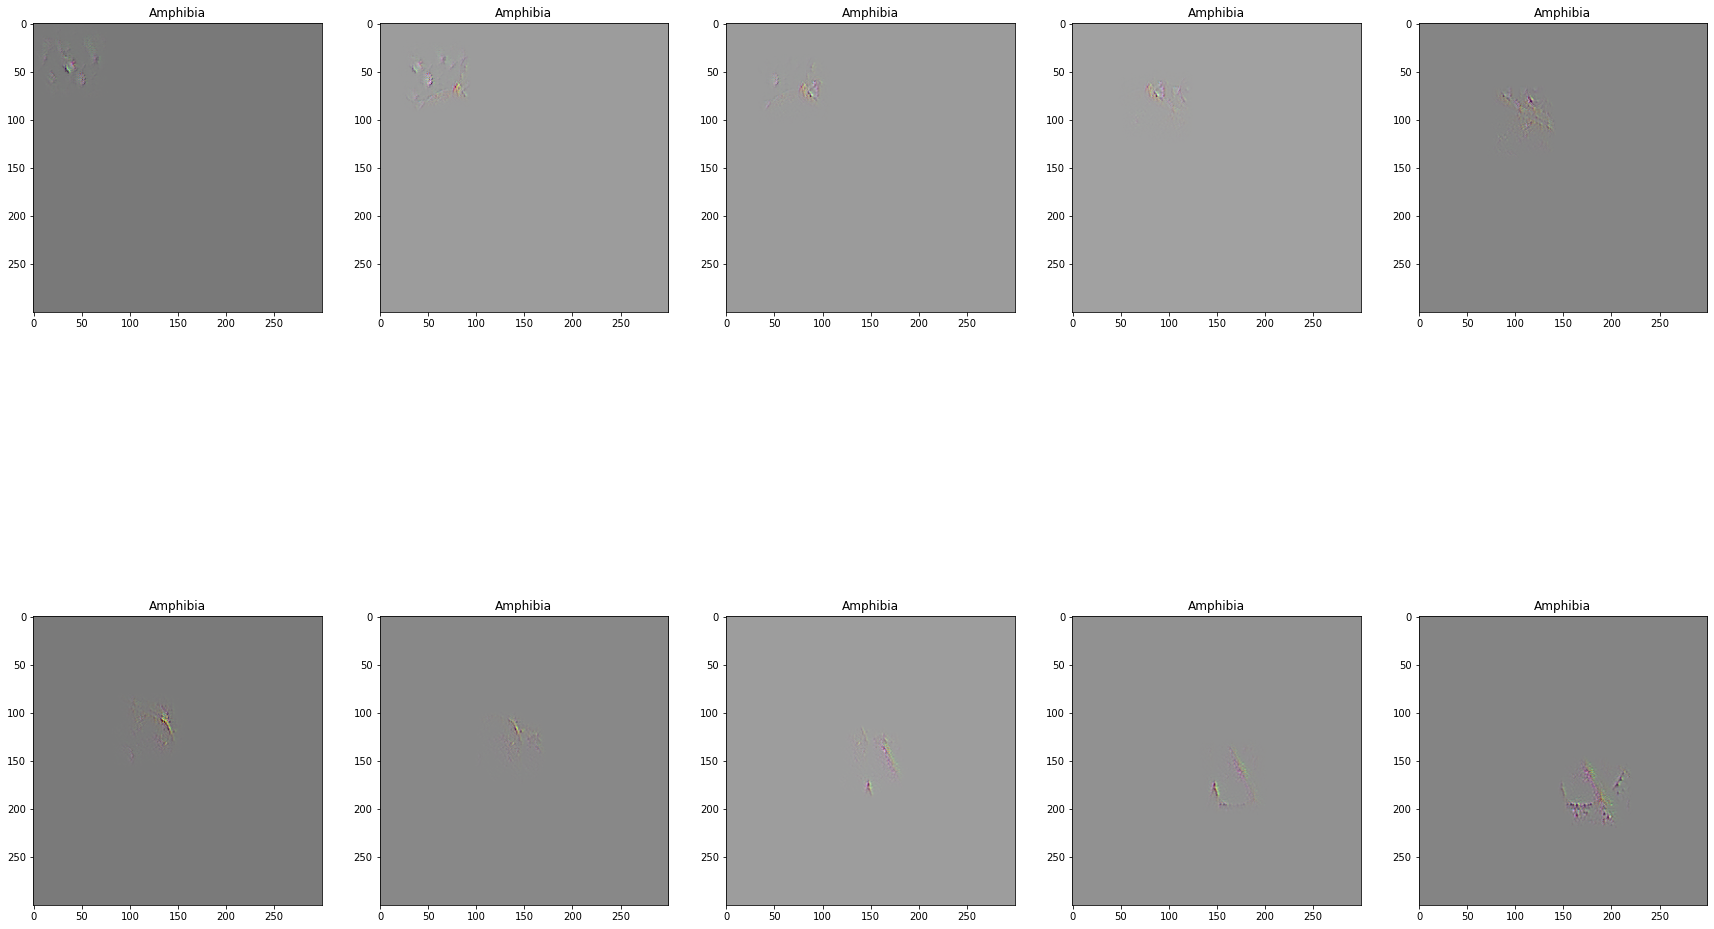

In [ ]:
GBP(model)

In [31]:
#Filter visualisation

def fil_vis(lay='conv1'):
  fil_model = tf.keras.models.Model(
      inputs = [model.inputs],    
      outputs = [model.get_layer(lay).output]
  )
  category = categories[0]
  dir=os.path.join(test_dir,category)
  for img in os.listdir(dir):
    img_path=(os.path.join(dir,img))
    imgs=cv2.imread(img_path)
    imgs=mpimg.imread(img_path)
    new_img=cv2.resize(imgs,(300,300))
    x = np.expand_dims(new_img, axis=0) 
    inputs = tf.cast(x, tf.float32)
    out = fil_model(inputs)[0]

      
  
    #f_min, f_max = out.min(), out.max()
    #filters = (out - f_min) / (f_max - f_min)
    # plot first few filters
    n_filters, ix = 16, 1
    plt.figure(figsize=(20,20))
    for i in range(n_filters):
      # get the filter
      f = out[:, :, i]
      # plot each channel separately
      for j in range(3):
        # specify subplot and turn of axis
        ax = plt.subplot(4, 4, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f)
      ix += 1
    # show the figure
    plt.show()
    break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


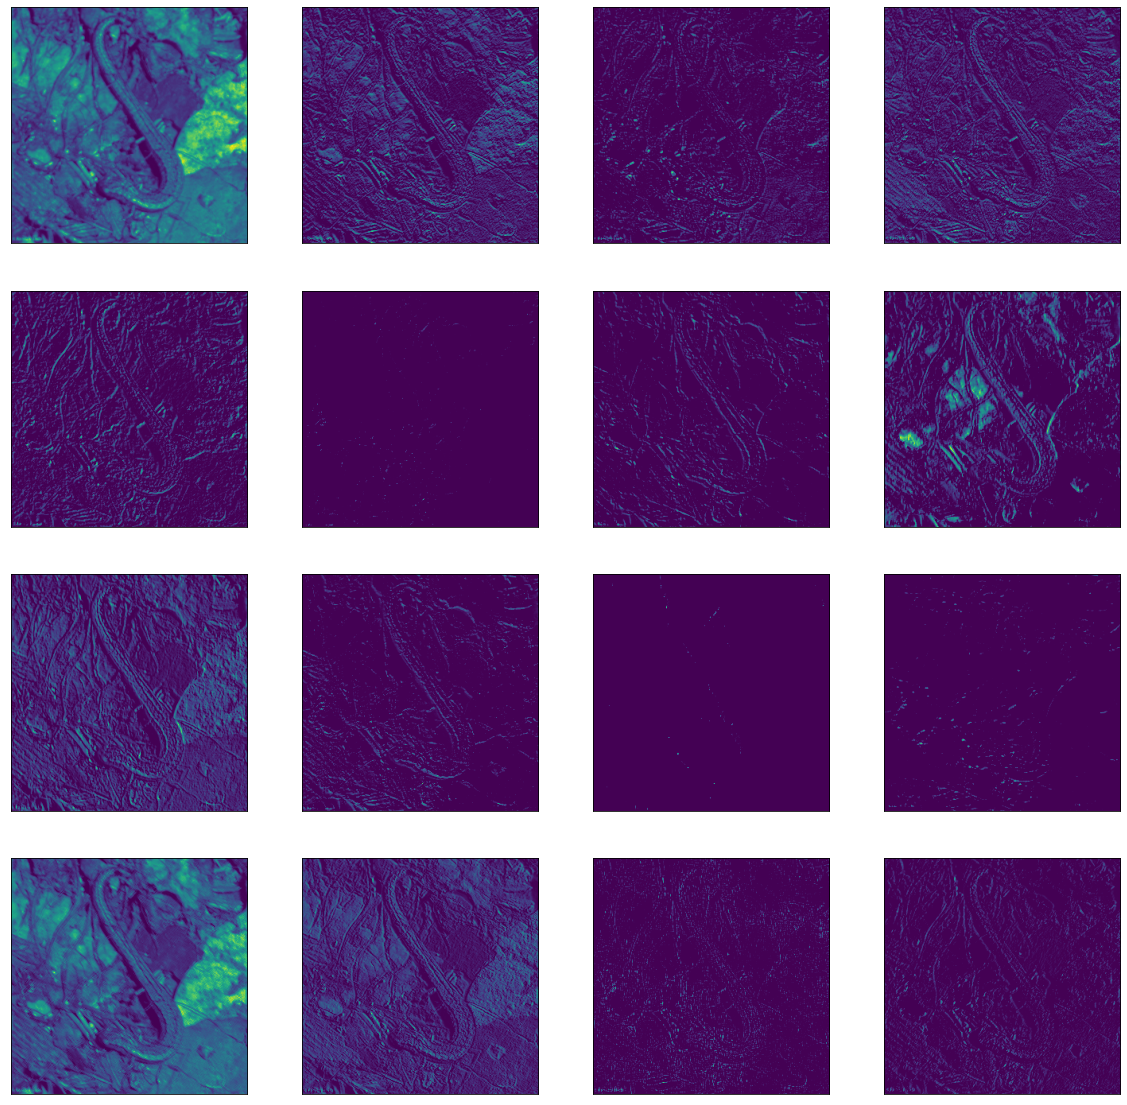

In [36]:
fil_vis(lay='conv1')